In [1]:
import numpy as np
import numba
from numba import jit
import pydicom
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import FuncFormatter, MultipleLocator
#divnorm=colors.TwoSlopeNorm(vcenter=0.)
import imageio
from scipy import interpolate
from skimage.filters import gaussian
plt.style.use(['science', 'notebook'])
import tomopy

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.measure import profile_line
from skimage.restoration import denoise_nl_means, estimate_sigma, richardson_lucy, unsupervised_wiener, wiener  
from functions import *

In [2]:
lam = 500
n = 400
L_val = 1/2
B_val = 1/5

Read original CT image and normalize to get reasonable attenuation coefficient $\mu(x,y)$

In [3]:
def normalize_phantom(A, p=0.5):
    n = A.shape[0]
    mu = -np.log(p)/n
    m = np.mean(A[A>0])
    return A*mu/m

A1 = imageio.imread('images/phantom1.png').sum(axis=2)
A2 = imageio.imread('images/phantom2.png').sum(axis=2)
A3 = imageio.imread('images/phantom3.png').sum(axis=2)
A4 = imageio.imread('images/phantom4.png').sum(axis=2)
A1_norm = normalize_phantom(A1, p=0.5)
A2_norm = normalize_phantom(A2, p=0.5)
A3_norm = normalize_phantom(A3, p=0.5)
A4_norm = normalize_phantom(A4, p=0.5)

A = A1
A_norm = A1_norm

Get all tumours and append to single array

In [4]:
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
n = A1.shape[0]
T = Ts.sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)

Add live and background and remove any overlapping tumours from liver

In [5]:
L = np.asarray(imageio.imread(f'images/liv.png').sum(axis=2))>260
B = np.asarray(imageio.imread(f'images/background.png').sum(axis=2))>260

Ts_non_overlap = []
for T in Ts:
    if not np.any(T*L):
        Ts_non_overlap.append(T)
T = np.array(Ts_non_overlap).sum(axis=0).astype(bool)
T_masked = np.ma.masked_where(~T, T)
B = B^(T+L)

In [6]:
T_masked = np.ma.masked_where(~T, T)
L_masked = np.ma.masked_where(~L, L)
B_masked = np.ma.masked_where(~B, B)
masks = [T_masked, L_masked, B_masked]
mask_names = ['T', 'L', 'B']

Get tumour distribution by smoothing the activity.

In [7]:
def get_tumour_dist(T, sigma=3):
    U = gaussian(T, sigma=3)
    U[~T]=0
    return U

U = get_tumour_dist(T, sigma=3)
U[L] += L_val
U[B] += B_val

In [8]:
p = PETImage(A1_norm, 500*U)

In [9]:
p.generate_PET_raw()

In [10]:
p.generate_PET_im()

In [11]:
p.generate_PET_sino()

In [12]:
p.get_probability_sinogram()

In [13]:
p.get_recon_data(['art'], masks, mask_names, correction=None, num_iters=[15])

# Plots for Paper

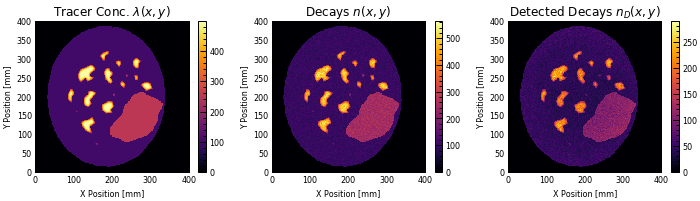

In [14]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
im = ax[0].pcolor(500*U, cmap='inferno')
c = plt.colorbar(im, ax=ax[0])
c.ax.tick_params(axis='y', labelsize=8)
ax[0].set_title('Tracer Conc. $\lambda(x,y)$', fontsize=12)
im = ax[1].pcolor(p.PET_raw, cmap='inferno')
c = plt.colorbar(im, ax=ax[1])
c.ax.tick_params(axis='y', labelsize=8)
ax[1].set_title('Decays $n(x,y)$', fontsize=12)
im = ax[2].pcolor(p.PET_im, cmap='inferno')
c = plt.colorbar(im, ax=ax[2])
c.ax.tick_params(axis='y', labelsize=8)
ax[2].set_title('Detected Decays $n_D(x,y)$', fontsize=12)
[a.tick_params(axis='x', labelsize=8) for a in ax]
[a.tick_params(axis='y', labelsize=8) for a in ax]
[a.set_xlabel('X Position [mm]', fontsize=8) for a in ax]
[a.set_ylabel('Y Position [mm]', fontsize=8) for a in ax]
fig.tight_layout()
plt.savefig('images/tumours.png', dpi=200)
plt.show()

In [15]:
ps = [PETImage(A, 500*U) for A in [A1_norm, A2_norm, A3_norm, A4_norm]]
for i,pi in enumerate(ps):
    print(i)
    pi.generate_PET_raw()
    pi.generate_PET_im()

0
1
2
3


/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lukepolson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


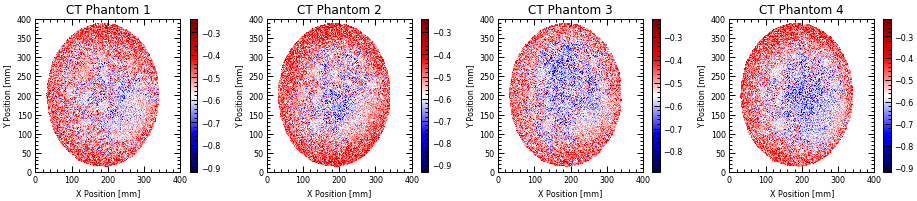

In [16]:
fig, ax = plt.subplots(1,4,figsize=(13,3))
for i in range(4):
    q = (ps[i].PET_im - ps[i].PET_raw)/(ps[i].PET_og)
    im = ax[i].pcolor(q, cmap='seismic')
    c = plt.colorbar(im, ax=ax[i])
    c.ax.tick_params(axis='y', labelsize=8)
    ax[i].set_title(f'CT Phantom {i+1}', fontsize=12)
[a.tick_params(axis='x', labelsize=8) for a in ax]
[a.tick_params(axis='y', labelsize=8) for a in ax]
[a.set_xlabel('X Position [mm]', fontsize=8) for a in ax]
[a.set_ylabel('Y Position [mm]', fontsize=8) for a in ax]
fig.tight_layout()
plt.savefig('images/ct_tumour_diff.png', dpi=200)
plt.show()

In [17]:
thetas, rs, sino_att = p.PET_im_sino_theta_bins, p.PET_im_sino_rs_bins, p.PET_im_sino
sino = sino_att/p.PET_im_sino_prob

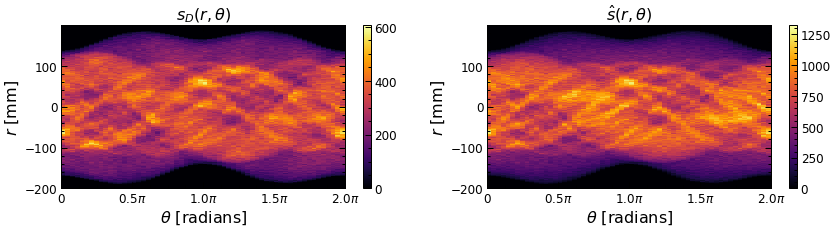

In [18]:
fig, axes = plt.subplots(1,2,figsize=(14,3))
ax = axes[0]
im = ax.pcolor(thetas, rs, sino_att, cmap='inferno')
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.1f}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/2))
ax.set_xlabel(r'$\theta$ [radians]')
ax.set_ylabel('$r$ [mm]')
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(axis='y', labelsize=12)
ax.set_title(r'$s_D(r,\theta)$')
ax = axes[1]
im = ax.pcolor(thetas, rs, sino, cmap='inferno')
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.1f}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/2))
ax.set_xlabel(r'$\theta$ [radians]')
ax.set_ylabel('$r$ [mm]')
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(axis='y', labelsize=12)
ax.set_title(r'$\hat{s}(r,\theta)$')
plt.savefig('images/sinos.png', dpi=200)
plt.show()

# Other Stuff

In [19]:
p = PETImage(A1_norm, 500*U)
p.generate_PET_raw()
p.generate_PET_im()
p.generate_PET_sino()
p.get_probability_sinogram()

In [61]:
algos = ['art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv']
iterations = [10, 250, 60, 30, 40, 40, 140, 200, 300, 360]
dps = np.array(iterations) / 10; dps=dps.astype(int)

In [53]:
%%capture
p.get_recon_data(algos, masks, mask_names, correction=None, num_iters=iterations)

MSE vs iterations

In [67]:
def plot_all_on_same(p, title, dps, T_val=500, L_val=250, B_val=100):
    fig = plt.figure(figsize=(20,5))
    plt.subplot(133)
    [plt.plot(np.abs(p.recon_datas[algo].data['T']['BIAS'][dps[i]:])/T_val*100,
              np.sqrt(p.recon_datas[algo].data['T']['VAR'][dps[i]:])/T_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)],
              ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    plt.ylabel('$\sigma$ [%]', fontsize=20)
    plt.xlabel('$|b|$ [%]', fontsize=20)
    plt.title(r'Tumours')
    plt.grid()
    plt.legend(ncol=2, fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
    #plt.ylim(8,16)
    #plt.xlim(6,28)

    plt.subplot(132)
    [plt.plot(np.abs(p.recon_datas[algo].data['L']['BIAS'][dps[i]:])/L_val*100,
              np.sqrt(p.recon_datas[algo].data['L']['VAR'][dps[i]:])/L_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)],
              ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    plt.ylabel('$\sigma$ [%]', fontsize=20)
    plt.xlabel('$|b|$ [%]', fontsize=20)
    plt.title(r'Liver')
    plt.grid()
    #plt.ylim(9,18)
    #plt.xlim(0,7)

    plt.subplot(131)
    [plt.plot(np.abs(p.recon_datas[algo].data['B']['BIAS'][dps[i]:])/B_val*100,
              np.sqrt(p.recon_datas[algo].data['B']['VAR'][dps[i]:])/B_val*100,
              marker=styles[i%len(styles)], color=colors[i%len(colors)],
              ls=linestyles[i%len(linestyles)], lw=1, label=algo) for i,algo in enumerate(algos)]
    plt.ylabel('$\sigma$ [%]', fontsize=20)
    plt.xlabel('$|b|$ [%]', fontsize=20)
    plt.title(r'Background')
    plt.ylim(18,46)
    plt.xlim(2,11)
    
    plt.grid()
    fig.suptitle(title, fontsize=20, y=1.05)
    fig.tight_layout()

In [68]:
linestyles = ['--', ':']

styles = [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'grey', 'pink')

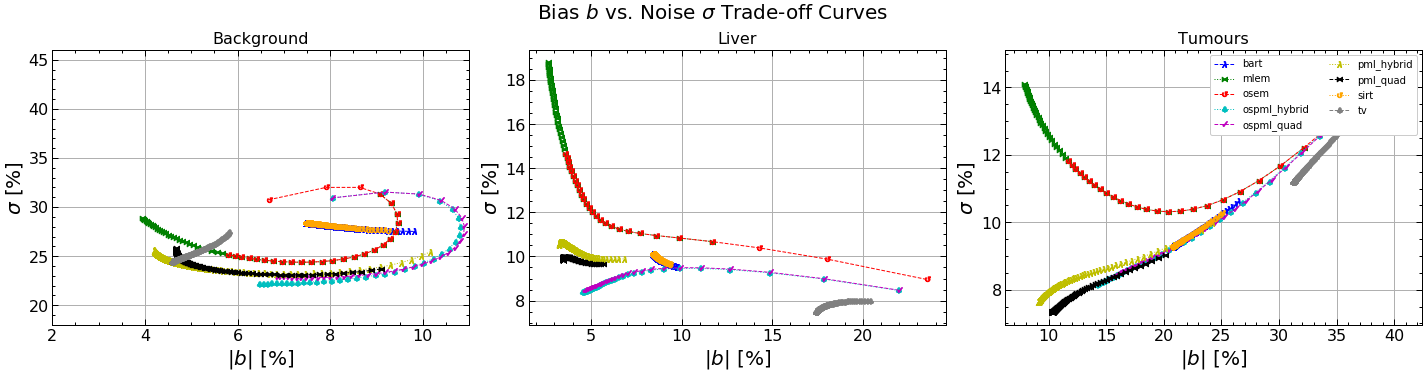

In [69]:
plot_all_on_same(p, 'Bias $b$ vs. Noise $\sigma$ Trade-off Curves', dps=dps)
#plt.savefig('images/bias_noise_tradeoff.png', dpi=200)
plt.show()

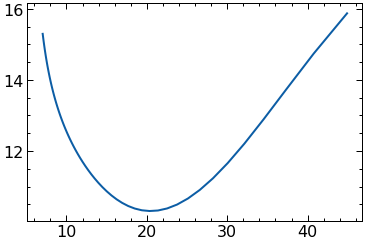

In [21]:
plt.plot(np.array(p.recon_datas['mlem'].data['T']['BIAS'][2:])/500*100,
         np.sqrt(p.recon_datas['mlem'].data['T']['VAR'][2:])/500*100)
plt.show()